In [ ]:
import pandas as pd
from pathlib import Path

cwd = Path().cwd() / 'dates/teste_atual'
# print(cwd)
files = []
for url in cwd.iterdir():
    print('arquivo: ', url.name)

    df = pd.read_csv(url, sep=',')
    print("Média pulsos:", df['CPM'].mean())
    files.append(df)

arquivo:  teste_23_10_2025_8cm.csv
Média pulsos: 209.8
arquivo:  teste_23_10_2025_10cm.csv
Média pulsos: 169.0
arquivo:  teste_21_10cm.csv
Média pulsos: 58.111111111111114
arquivo:  teste_21_15cm.csv
Média pulsos: 42.95
arquivo:  teste_23_10_2025_2cm.csv
Média pulsos: 584.8
arquivo:  teste_23_10_2025_6cm.csv
Média pulsos: 246.5
arquivo:  teste_23_10_2025_4cm.csv
Média pulsos: 361.6
arquivo:  teste_21__back_ground.csv
Média pulsos: 54.75
arquivo:  teste_23_10_2025_12cm.csv
Média pulsos: 175.66666666666666


In [2]:
back_ground = cwd / 'teste_21__back_ground.csv'

df = pd.read_csv(back_ground, sep=',')
df['CPM'].mean()

np.float64(54.75)

Parâmetros de ajuste: k = 25205.75, d = 4.93
R-Quadrado (R²): 0.9876


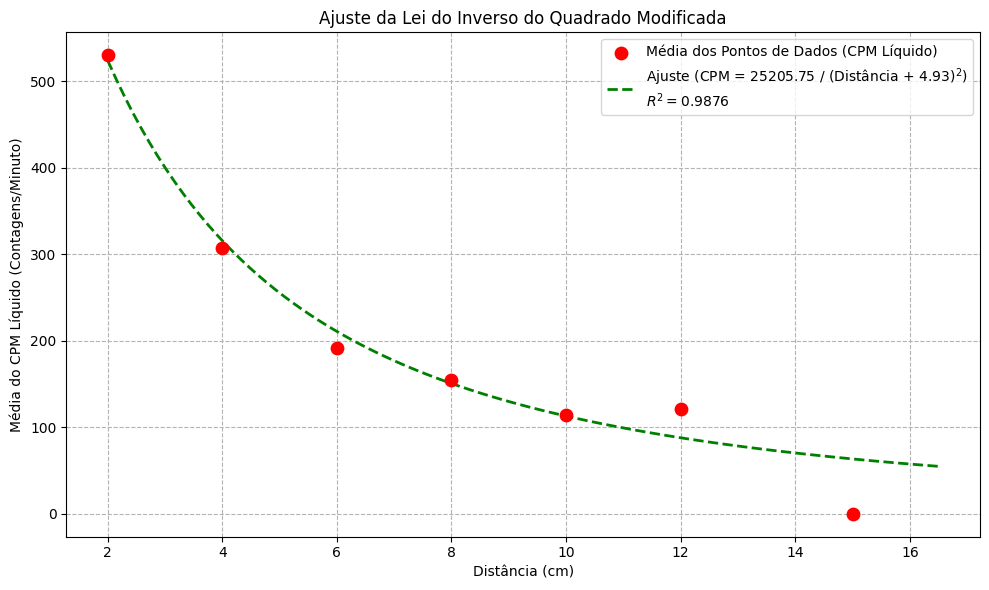


--- Dados Médios Utilizados ---
|   Distância (cm) |   CPM Líquido |
|-----------------:|--------------:|
|             2.00 |        530.05 |
|             4.00 |        306.85 |
|             6.00 |        191.75 |
|             8.00 |        155.05 |
|            10.00 |        114.25 |
|            12.00 |        120.92 |
|            15.00 |          0.00 |


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# ====================================================================
# CONFIGURAÇÃO E DADOS
# ====================================================================

# O valor do Background (fundo de radiação)
CPM_BACKGROUND = 54.75 

data_raw = [
    {'Distance_cm': 2, 'CPM_Raw': 584.8},
    {'Distance_cm': 4, 'CPM_Raw': 361.6},
    {'Distance_cm': 6, 'CPM_Raw': 246.5},
    {'Distance_cm': 8, 'CPM_Raw': 209.8},
    {'Distance_cm': 10, 'CPM_Raw': 169.0},
    {'Distance_cm': 12, 'CPM_Raw': 175.66666666666666},
    {'Distance_cm': 15, 'CPM_Raw': 42.95},
]

df_raw = pd.DataFrame(data_raw)

# 1. Pré-Processamento dos Dados
# --------------------------------------------------------------------

# Calcular o CPM Líquido (ajustado pelo background)
df_raw['CPM_Net'] = np.maximum(0, df_raw['CPM_Raw'] - CPM_BACKGROUND)

# Calcular a Média do CPM Líquido para cada Distância (para pontos repetidos)
df_grouped = df_raw.groupby('Distance_cm', as_index=False)['CPM_Net'].mean()

# Ordenar os dados pela Distância
df_sorted = df_grouped.sort_values(by='Distance_cm')

# 2. Preparação para o Ajuste
# --------------------------------------------------------------------

# Excluir pontos com CPM Líquido próximo de zero para ajuste estável (principalmente 15cm)
df_fit = df_sorted[df_sorted['CPM_Net'] > 1.0].copy() 

D = df_fit['Distance_cm'].values
CPM = df_fit['CPM_Net'].values

# 3. Função de Ajuste: Lei do Inverso do Quadrado MODIFICADA
# Modelagem: CPM = k / (D + d)^2 
# 'd' corrige a distância efetiva da fonte.
def inverse_square_law(D, k, d):
    return k / ((D + d) ** 2)

# Parâmetros iniciais (p0)
p0 = [20000, 4] 

# 4. Ajuste de Curva e Cálculo do R²
# --------------------------------------------------------------------
try:
    params, covariance = curve_fit(inverse_square_law, D, CPM, p0=p0, maxfev=5000)
    k_fit, d_fit = params

    # Cálculo do R-quadrado
    residuals = CPM - inverse_square_law(D, k_fit, d_fit)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((CPM - np.mean(CPM))**2)
    r_squared = 1 - (ss_res / ss_tot)
    
    print(f"Parâmetros de ajuste: k = {k_fit:.2f}, d = {d_fit:.2f}")
    print(f"R-Quadrado (R²): {r_squared:.4f}")

    # 5. Plotagem do Gráfico
    # --------------------------------------------------------------------
    
    # Gerar pontos para traçar a curva ajustada
    D_plot = np.linspace(df_sorted['Distance_cm'].min(), df_sorted['Distance_cm'].max() * 1.1, 100)
    CPM_fit_plot = inverse_square_law(D_plot, k_fit, d_fit)

    plt.figure(figsize=(10, 6))
    
    # Plotar Pontos (Médias Coletadas)
    plt.scatter(df_sorted['Distance_cm'], df_sorted['CPM_Net'], 
                color='red', zorder=5, label='Média dos Pontos de Dados (CPM Líquido)', s=80)
    
    # Plotar Curva Ajustada
    equation_label = f'Ajuste (CPM = {k_fit:.2f} / (Distância + {d_fit:.2f})$^2$)\n$R^2 = {r_squared:.4f}$'
    plt.plot(D_plot, CPM_fit_plot, 'g--', zorder=2, label=equation_label, linewidth=2)

    plt.title('Ajuste da Lei do Inverso do Quadrado Modificada')
    plt.xlabel('Distância (cm)')
    plt.ylabel('Média do CPM Líquido (Contagens/Minuto)')
    plt.legend(loc='best')
    plt.grid(True, which="both", ls="--", c='0.7')
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"\nERRO no ajuste de curva. Plotando apenas os pontos de dispersão. Erro: {e}")
    plt.figure(figsize=(10, 6))
    plt.scatter(df_sorted['Distance_cm'], df_sorted['CPM_Net'], color='red', label='Média dos Pontos de Dados (CPM Líquido)', s=80)
    plt.title('Contagens por Minuto (CPM) em Função da Distância')
    plt.xlabel('Distância (cm)')
    plt.ylabel('Média do CPM Líquido')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

print("\n--- Dados Médios Utilizados ---")
print(df_sorted[['Distance_cm', 'CPM_Net']].rename(columns={'Distance_cm': 'Distância (cm)', 'CPM_Net': 'CPM Líquido'}).to_markdown(index=False, floatfmt=".2f"))